<a href="https://colab.research.google.com/github/alighasemi78/persian_paraphraser/blob/main/creating_fa_t5_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating fa-t5-base

In this notebook, I will adapt the [google/mt5-base](https://huggingface.co/google/mt5-base) for Farsi.

## Installing the Required Libraries

In [ ]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the Required Libraries

In [ ]:
from google.colab import drive
from transformers import T5ForConditionalGeneration, T5Tokenizer
import pandas as pd
import csv
from collections import Counter
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import torch

## Connecting to Google Drive

In [ ]:
drive.mount('/content/gd')

Drive already mounted at /content/gd; to attempt to forcibly remount, call drive.mount("/content/gd", force_remount=True).


## MT5 Model

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('google/mt5-base')
tokenizer = T5Tokenizer.from_pretrained("google/mt5-base")

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


The tokenizer contains over 250K tokens.

In [ ]:
tokenizer.vocab_size

250100

The model has over 582M parameters.

In [ ]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.shared))
print('encoder')
print(msize(model.encoder))
print(msize(model.encoder.block))
print('decoder')
print(msize(model.decoder))
print(msize(model.decoder.block))
print(msize(model.lm_head))

582401280
192086016
encoder
277040256
84953472
decoder
305361024
113274240
192086016


## Determine Language-Specific Tokens

In order to find the tokens for Farsi, we need a huge Farsi corpus with compare to the model and find the similar tokens. You can download [this](https://downloads.wortschatz-leipzig.de/corpora/fas-ir_web-public_2019_1M.tar.gz) file which contains 1M Farsi sentences.
Moreover, there may be some English words in Farsi Sentences. We don't want to miss them. So we also need an English corpus to do the same thing with English. Then we can choose a percentage of our model to have English tokens. You can download [this](https://downloads.wortschatz-leipzig.de/corpora/eng-com_web-public_2018_1M.tar.gz) file which contains 1M English sentences.

### Farsi Dataset

In [ ]:
dataset_path = "/content/gd/MyDrive/Undergraduate Studies/Semester 9/Computer Engineering Project/Adapting MT5 model for Farsi/fas-ir_web-public_2019_1M-sentences.txt"
farsi_dataset = pd.read_csv(dataset_path, sep='\t', header=None, quoting=csv.QUOTE_NONE)
farsi_dataset.columns = ['idx', 'text']

In [ ]:
farsi_dataset

,idx,text
0,1,۰۰۰ (پانصدهزار) ریال به شماره حساب ۲۱۷۲۳۴۳۵۰۱۰...
1,2,۰۰۰تن لاستیک تولید میکند که از این مقدار با رش...
2,3,۰۰۰ تومان بجای ۹۰.
3,4,۰۰۰ تومان/ سیگنال سیاسی بر بازار ارز اثر گذاشت؟
4,5,۰۰۰ تومانی قیمت گوشت قرمز/ خطر کاهش…
...,...,...
999995,999996,ييلاق و قشلاق است بيرون و درون است گاهی آنجا و...
999996,999997,ڪے شود حــر شوم و توبهـ ے مردانهـ ڪنم.
999997,999998,Χ عوارض و موارد احتیاط: استفاده از این گیاه بر...
999998,999999,Официальный сайт великого аятоллы Макарема Шир...


### English Dataset

In [ ]:
dataset_path = "/content/gd/MyDrive/Undergraduate Studies/Semester 9/Computer Engineering Project/Adapting MT5 model for Farsi/eng-com_web-public_2018_1M-sentences.txt"
english_dataset = pd.read_csv(dataset_path, sep='\t', header=None, quoting=csv.QUOTE_NONE)
english_dataset.columns = ['idx', 'text']

In [ ]:
english_dataset

,idx,text
0,1,“0 percent interest!” the ads blare.
1,2,"$0 to $10,000 for married couples filing separ..."
2,3,"$1,000,000 - A new millionaire in the Capitale..."
3,4,"$10,000 to help support two regional youth con..."
4,5,"$100 daily prizes and grand prize of $1,000 wi..."
...,...,...
999995,999996,身為公司擁有人，您應該是 Google My Business 帳戶的主要擁有人。
999996,999997,车辆检测器 - 线圈式车辆检测器 - 车辆检测器 - 产品 - SWARCO ITS We ...
999997,999998,通过在页面配置（pom.xml 文件）中指定有效的 Google Cloud Analyti...
999998,999999,通过访问 Visual Studio 在 Windows 上提供的你所熟悉和喜爱的相同的编译...


### Counting the Tokens

In [ ]:
cnt_fa = Counter()
for text in tqdm(farsi_dataset.text):
    cnt_fa.update(tokenizer.encode(text))

cnt_en = Counter()
for text in tqdm(english_dataset.text):
    cnt_en.update(tokenizer.encode(text))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

The tokens that are ever used with Farsi are about 13% of the whole vocabulary. With English, it is about 27%.

Surprisingly, there is more than 70% overlap between the vocabularies. Perhaps, this is because in Farsi texts there are occasionally English words or other words with latin alphabet.

In [ ]:
print(len(cnt_fa), len(cnt_fa)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
common = len(set(cnt_fa.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_fa))

34423 0.13763694522191122
67920 0.2715713714514194
24472 0.7109200244022892


For Farsi, 10K tokens cover about 99% of the vocabulary.

For English, 10K tokens cover about 95% of the vocabulary, and 20K - about 99%.

In [ ]:
print('fa')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_fa.most_common(top)) / sum(cnt_fa.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))

fa
10000 0.9985717701883996
20000 0.9995678215028926
30000 0.9998857426483738
en
10000 0.9531899764307693
20000 0.9840809828270257
30000 0.9937869259525808


Remember the old vocabulary, because we are going to replace it soon!

In [ ]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

Look at the most used tokens. They are mostly service words or prefixes.

In [ ]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_fa.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(30)]))

['▁', '</s>', '▁و', '.', '▁در', 'ی', '▁به', 'ه', '،', '▁از', '▁که', '▁را', '▁این', '▁است', '▁می', '▁با', '▁م', 'م', '▁هم', 'های', '▁آن', 'ند', 'ت', 'ن', 'ها', 'ان', '▁بر', 'د', ':', 'برای']
['▁', '</s>', '.', '▁the', ',', 's', '▁to', '▁and', 'a', '▁of', '▁in', '▁is', '▁I', '’', '▁that', 'ed', '▁for', '-', 'ing', "'", '▁you', '▁it', '▁with', '▁on', 'ly', 'y', '▁be', '▁The', '▁as', '▁are']


## Choosing the New Tokens

We try the following composition of vocabulary:
* 100 of top tokens of the original tokenizer (just in case)
* Top 3K of the English vocabulary
* Top 4K of the Farsi vocabulary (or more, to make the total number of tokens 7K)
* 100 special tokens that T5 uses

In [ ]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_en.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)
for i, (k, v) in enumerate(cnt_fa.most_common(25_000)):
    if len(new_tokens) == 29_900:
        print(i, 'Farsi tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print(len(new_tokens))
kept_ids = sorted(new_tokens)

23432 Farsi tokens are included
30000


The new vocabulary is only 2% of the original one.

In [ ]:
len(kept_ids) / tokenizer.vocab_size

0.11995201919232307

The plot shows that the tokens that were more frequent in the original vocabulary, more frequently get into the new vocabulary (so that the curve bends upward).

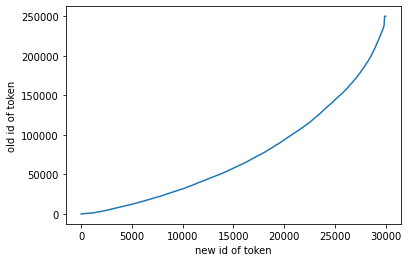

In [ ]:
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

## Updating the Model

In [ ]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [ ]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [ ]:
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

The new model has 208M parameters - 35% of the original size. 

In [ ]:
print(msize(model), msize(model) / original_size)

244309248 0.4194861110195362


## Updating the Tokenizer

T5 uses Sentencepiece tokenizer, which is implemented in C and is opaque to Python. 

Fortunately, we can download its model and deploy it into Python using its Protobuf representation. 

https://github.com/google/sentencepiece/issues/121

In [ ]:
!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

--2022-12-07 19:22:42--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451 (13K) [text/plain]
Saving to: ‘sentencepiece_model.proto.1’

sentencepiece_model 100%[===================>]  13.14K  --.-KB/s    in 0s      

2022-12-07 19:22:42 (98.4 MB/s) - ‘sentencepiece_model.proto.1’ saved [13451/13451]



We compile the protobuf description of the sentencepiece model in order to be able to modify it.

In [ ]:
!protoc --python_out=. sentencepiece_model.proto

Now we can serialize the model used by the current tokenizer and open it as a protobuf class.

In [ ]:
import sentencepiece_model_pb2 as spmp

smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))

# replace the content of the first 7K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 30000


  0%|          | 0/220100 [00:00<?, ?it/s]

30000


In [ ]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)

## Saving the Model

In [ ]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'alighasemi/fa-t5-base'
model.config

T5Config {
  "_name_or_path": "alighasemi/fa-t5-base",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_size": 30000
}

In [ ]:
new_tokenizer.save_pretrained('fa-t5-base')
model.save_pretrained('fa-t5-base')

In [ ]:
!ls fa-t5-base -alsh

total 933M
4.0K drwxr-xr-x 2 root root 4.0K Dec  7 19:25 .
4.0K drwxr-xr-x 1 root root 4.0K Dec  7 19:25 ..
4.0K -rw-r--r-- 1 root root  801 Dec  7 19:25 config.json
933M -rw-r--r-- 1 root root 933M Dec  7 19:25 pytorch_model.bin
4.0K -rw-r--r-- 1 root root   74 Dec  7 19:25 special_tokens_map.json
740K -rw-r--r-- 1 root root 738K Dec  7 19:25 spiece.model
4.0K -rw-r--r-- 1 root root  245 Dec  7 19:25 tokenizer_config.json


## Testing the Model

In [ ]:
model1 = T5ForConditionalGeneration.from_pretrained('fa-t5-base')
tokenizer1 = T5Tokenizer.from_pretrained('fa-t5-base')

In [ ]:
inputs = tokenizer1('The <extra_id_0> walks in <extra_id_1> park.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0> closest <extra_id_1> the <extra_id_2> this <extra_id_3> beach <extra_id_4> the beautiful national <extra_id_5> natural pool</s>
<pad> <extra_id_0> house <extra_id_1> the <extra_id_2> nature at a <extra_id_3> man</s><pad><pad><pad><pad><pad>
<pad> <extra_id_0> latest <extra_id_1> the <extra_id_2> public <extra_id_3> Grand <extra_id_4> the <extra_id_5> grand-summer at</s>


In [ ]:
inputs = tokenizer1('<extra_id_0> زیبا در حال قدم زدن <extra_id_1> در پارک است.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0> زیبا <extra_id_1> خود <extra_id_2> به پارک با.</s><pad>
<pad> <extra_id_0> هارمونی بسیار <extra_id_1> شان <extra_id_2> دارند.</s>
<pad> <extra_id_0> یهودست آن <extra_id_1> زیبا <extra_id_2> است.</s>


## Uploading the Model to Huggingface

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
model1.push_to_hub('fa-t5-base')
tokenizer1.push_to_hub('fa-t5-base')

CommitInfo(commit_url='https://huggingface.co/alighasemi/fa-t5-base/commit/ae94954e148be946ac5482176551591b924e6bd3', commit_message='Upload tokenizer', commit_description='', oid='ae94954e148be946ac5482176551591b924e6bd3', pr_url=None, pr_revision=None, pr_num=None)